#Data Preperation

In [4]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds

# Load and preprocess the Kuzushiji MNIST dataset
def load_and_preprocess_data():
    (train_data, test_data), ds_info = tfds.load('kmnist', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)

    # Normalize images and flatten them to vectors of size 784 (28x28)
    def preprocess(image, label):
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.reshape(image, [-1])
        return image, label

    train_data = train_data.map(preprocess).batch(1024)
    test_data = test_data.map(preprocess).batch(1024)

    def extract_data(dataset):
        images, labels = [], []
        for image, label in dataset:
            images.append(image.numpy())
            labels.append(label.numpy())
        return np.concatenate(images), np.concatenate(labels)

    train_images, train_labels = extract_data(train_data)
    test_images, test_labels = extract_data(test_data)

    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = load_and_preprocess_data()

split_index = int(0.8 * len(train_images))
X_train, X_val = train_images[:split_index], train_images[split_index:]
y_train, y_val = train_labels[:split_index], train_labels[split_index:]

from tensorflow.keras.utils import to_categorical
y_train_oh = to_categorical(y_train, 10)
y_val_oh = to_categorical(y_val, 10)
y_test_oh = to_categorical(test_labels, 10)


#Radial Basis Function (RBF) Network


In [8]:
from sklearn.cluster import KMeans
import numpy as np

class RBFNetwork:
    def __init__(self, input_dim, num_rbf_units, output_dim):
        self.input_dim = input_dim
        self.num_rbf_units = num_rbf_units
        self.output_dim = output_dim
        self.centers = None
        self.weights = np.random.randn(self.num_rbf_units, self.output_dim)
        self.beta = 1.0

    # Gaussian radial basis function
    def gaussian_rbf(self, X, center):
        return np.exp(-self.beta * np.linalg.norm(X - center, axis=1) ** 2)

    # RBF layer to compute activations
    def rbf_layer(self, X):
        rbf_outputs = np.array([self.gaussian_rbf(X, c) for c in self.centers])
        return rbf_outputs.T  # Transpose to match (num_samples, num_rbf_units)

    # Softmax function for output layer
    def softmax(self, X):
        exp_scores = np.exp(X - np.max(X, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Forward pass through the RBF network
    def forward(self, X):
        rbf_out = self.rbf_layer(X)
        output = np.dot(rbf_out, self.weights)
        return self.softmax(output)

    # Initialize centers using K-means clustering
    def kmeans_centers(self, X):
        kmeans = KMeans(n_clusters=self.num_rbf_units, random_state=0).fit(X)
        self.centers = kmeans.cluster_centers_

    # Loss function (cross-entropy)
    def compute_loss(self, output, y_true):
        m = y_true.shape[0]
        log_likelihood = -np.log(output[range(m), y_true])
        loss = np.sum(log_likelihood) / m
        return loss

    # Compute the gradient of the loss with respect to weights
    def compute_gradient(self, X, rbf_out, output, y_true):
        m = y_true.shape[0]
        delta = output
        delta[range(m), y_true] -= 1
        dW = np.dot(rbf_out.T, delta) / m
        return dW

    # Training function with gradient descent
    def train(self, X, y, epochs=100, learning_rate=0.01):
        self.kmeans_centers(X)  # Initialize centers using K-means
        for epoch in range(epochs):
            rbf_out = self.rbf_layer(X)
            output = np.dot(rbf_out, self.weights)
            softmax_output = self.softmax(output)

            loss = self.compute_loss(softmax_output, y)
            grad_weights = self.compute_gradient(X, rbf_out, softmax_output, y)

            # Update weights using gradient descent
            self.weights -= learning_rate * grad_weights

            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss}')



#Train the RBF Network

In [9]:
# Initialize and train the RBF network
rbf_net = RBFNetwork(input_dim=784, num_rbf_units=10, output_dim=10)
rbf_net.train(X_train, y_train, epochs=100, learning_rate=0.01)


Epoch 0, Loss: 2.302585092994047
Epoch 10, Loss: 2.302585092994047
Epoch 20, Loss: 2.302585092994047
Epoch 30, Loss: 2.302585092994047
Epoch 40, Loss: 2.302585092994047
Epoch 50, Loss: 2.302585092994047
Epoch 60, Loss: 2.302585092994047
Epoch 70, Loss: 2.302585092994047
Epoch 80, Loss: 2.302585092994047
Epoch 90, Loss: 2.302585092994047


#Evaluate the Model

Test Accuracy: 10.36%
Confusion Matrix:
[[ 999    1    0    0    0    0    0    0    0    0]
 [ 902   30    0   68    0    0    0    0    0    0]
 [ 936    9    0   55    0    0    0    0    0    0]
 [ 983    1    1    4    0   11    0    0    0    0]
 [ 977    6    1   16    0    0    0    0    0    0]
 [ 938   11    0   40    8    3    0    0    0    0]
 [ 848   30    0  122    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [ 941   11    4   44    0    0    0    0    0    0]
 [ 993    0    0    7    0    0    0    0    0    0]]


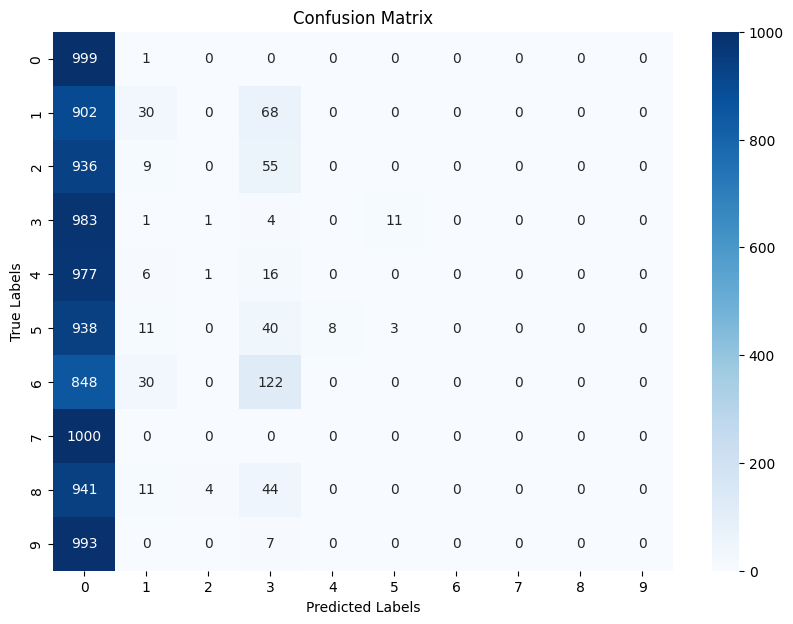

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

test_pred = rbf_net.forward(test_images)
test_pred_labels = np.argmax(test_pred, axis=1)

accuracy = accuracy_score(test_labels, test_pred_labels)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

conf_matrix = confusion_matrix(test_labels, test_pred_labels)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


#Analysis

In [11]:
# Analysis of strengths and limitations of RBF Network
print("""
Strengths of RBF Network:
- The RBF network is inherently good at handling non-linear data, which helps classify complex datasets.
- It can approximate any function with enough RBF units, making it a powerful model for many types of classification tasks.

Limitations:
- The choice of the number of RBF units has a significant impact on performance.
- The model can be sensitive to the distribution of centers, which may lead to suboptimal results if the K-Means algorithm does not find appropriate centers.
- The training process with gradient descent can be slow, especially for large datasets.
""")

# Discuss the impact of RBF units
print("""
Increasing the number of RBF units typically improves the network's ability to fit the data, but it may also lead to overfitting, especially on smaller datasets.
A good balance between the number of RBF units and regularization should be found to achieve optimal performance.
""")



Strengths of RBF Network:
- The RBF network is inherently good at handling non-linear data, which helps classify complex datasets.
- It can approximate any function with enough RBF units, making it a powerful model for many types of classification tasks.

Limitations:
- The choice of the number of RBF units has a significant impact on performance.
- The model can be sensitive to the distribution of centers, which may lead to suboptimal results if the K-Means algorithm does not find appropriate centers.
- The training process with gradient descent can be slow, especially for large datasets.


Increasing the number of RBF units typically improves the network's ability to fit the data, but it may also lead to overfitting, especially on smaller datasets.
A good balance between the number of RBF units and regularization should be found to achieve optimal performance.

